In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, GaussianNoise, ZerosInputs
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0., noise=False, zeros=False):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        
        self.noise = noise
        if noise:
            self.noise_mod = GaussianNoise()
            
        self.zeros = zeros
        if zeros:
            self.zero_inputs = ZerosInputs()
        
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        if self.noise:
            x = self.noise_mod(x)
        
        if self.zeros:
            x = self.zero_inputs(x)

        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'default': Net(32), 'noise': Net(32, noise=True), 'zeros': Net(32, zeros=True)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 1.018860 noise: 1.011410 zeros: 1.028023
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.612991 noise: 0.611982 zeros: 0.619401
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.432217 noise: 0.431135 zeros: 0.440094
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.333806 noise: 0.339748 zeros: 0.346320
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.308057 noise: 0.317198 zeros: 0.322693
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.278456 noise: 0.290368 zeros: 0.296405
Test set:
default: loss: 0.2789	rho_loss: 0.0272
noise: loss: 0.2855	rho_loss: 0.0272
zeros: loss: 0.3128	rho_loss: 0.0274

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.268301 noise: 0.281777 zeros: 0.288317
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.262714 noise: 0.277799 zeros: 0.287489
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.256334 noise: 0.276049 zeros: 0.287205
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.2468

Train Epoch: 13 [20000/50000 (40%)]	Losses default: 0.093558 noise: 0.128181 zeros: 0.153256
Train Epoch: 13 [30000/50000 (60%)]	Losses default: 0.096622 noise: 0.127353 zeros: 0.155971
Train Epoch: 13 [40000/50000 (80%)]	Losses default: 0.097388 noise: 0.131418 zeros: 0.158929
Train Epoch: 13 [50000/50000 (100%)]	Losses default: 0.094563 noise: 0.126798 zeros: 0.148716
Test set:
default: loss: 0.0964	rho_loss: 0.0272
noise: loss: 0.1195	rho_loss: 0.0275
zeros: loss: 0.2005	rho_loss: 0.0311

Train Epoch: 14 [0/50000 (0%)]	Losses default: 0.093988 noise: 0.127501 zeros: 0.151270
Train Epoch: 14 [10000/50000 (20%)]	Losses default: 0.088066 noise: 0.121280 zeros: 0.143238
Train Epoch: 14 [20000/50000 (40%)]	Losses default: 0.090607 noise: 0.126501 zeros: 0.151338
Train Epoch: 14 [30000/50000 (60%)]	Losses default: 0.097294 noise: 0.129736 zeros: 0.157817
Train Epoch: 14 [40000/50000 (80%)]	Losses default: 0.089443 noise: 0.121984 zeros: 0.145770
Train Epoch: 14 [50000/50000 (100%)]	Losses

In [13]:
data, _ = next(iter(test_loader))
to_plot = {}
f_to_plot = {}
dec_to_plot = {}

for k, model in models.items():
    output = model(data)
    to_plot[k] = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
    decoded = model.decode(torch.eye(32))
    dec_to_plot[k] = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
    with torch.no_grad():
        encoded = model.E(data.view(-1, 28*28))
        print((encoded > 0.5).sum(1))
        encoded[encoded < 0.5] = 0.
        decoded_f = model.decode(encoded)
        f_to_plot[k] = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([20, 17, 19, 20, 14, 18, 18, 18, 16, 18, 17, 17, 20, 19, 19, 16, 18, 17,
        10, 19, 17, 20, 17, 21, 19, 12, 19, 20, 16, 17, 18, 18, 14, 15, 17, 17,
        17, 18, 20, 19, 22, 23, 16, 18, 17, 18, 19, 16, 14, 14])
tensor([16, 16, 21, 16, 17, 18, 13, 16, 15, 17, 13, 13, 19, 17, 18, 14, 18, 20,
        11, 18, 18, 18, 14, 21, 17, 13, 18, 15, 19, 17, 17, 19, 14, 13, 21, 12,
        19, 16, 17, 17, 21, 19, 17, 17, 17, 17, 14, 22, 13, 14])
tensor([18, 11, 17, 15, 15, 14, 13, 15, 12, 13, 11, 11, 15, 16, 15, 14, 13, 15,
         8, 18, 11, 18, 13, 18, 17, 13, 14, 15, 16, 15, 16, 17, 12, 13, 16, 13,
        14, 16, 16, 14, 17, 16, 15, 10, 16, 16, 14, 12, 15, 10])


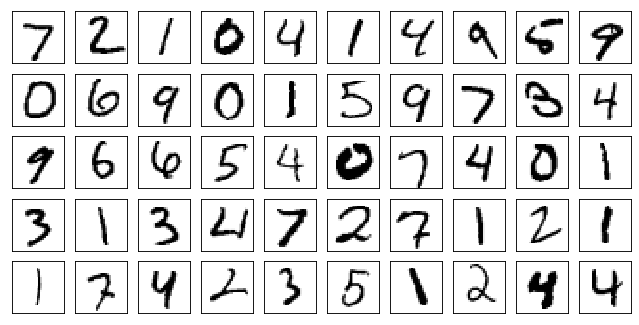

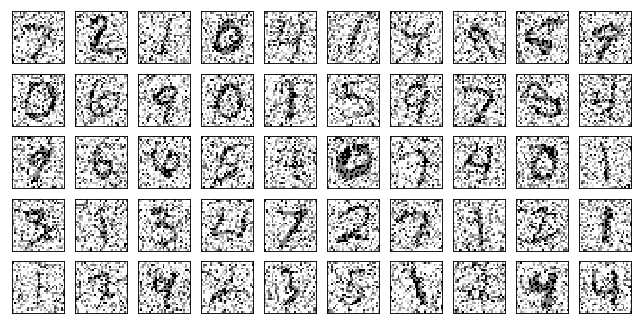

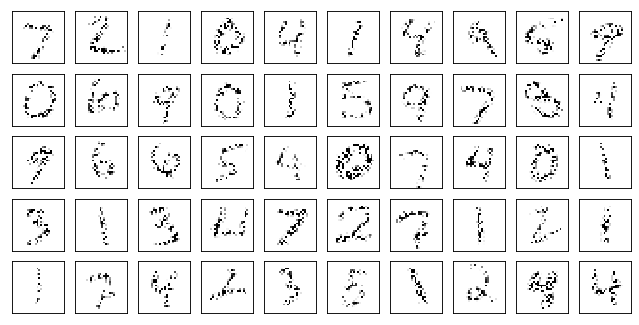

default


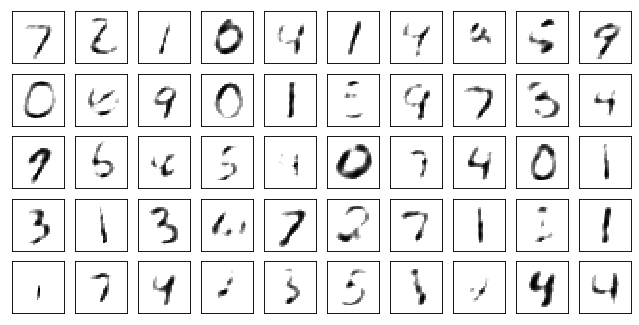

noise


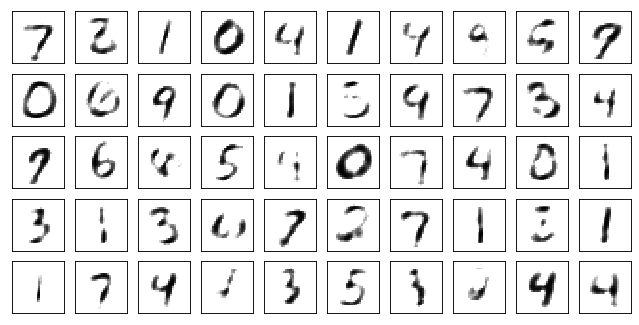

zeros


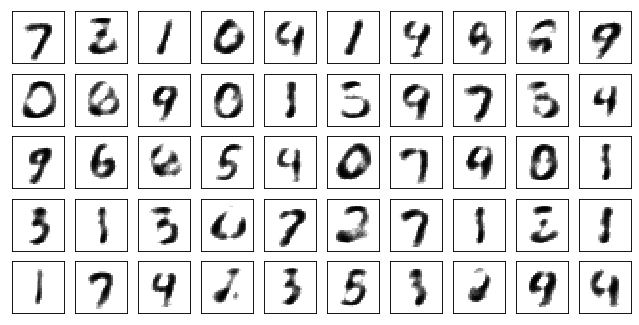

default


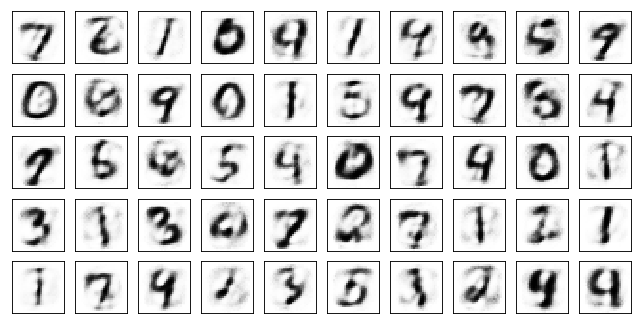

noise


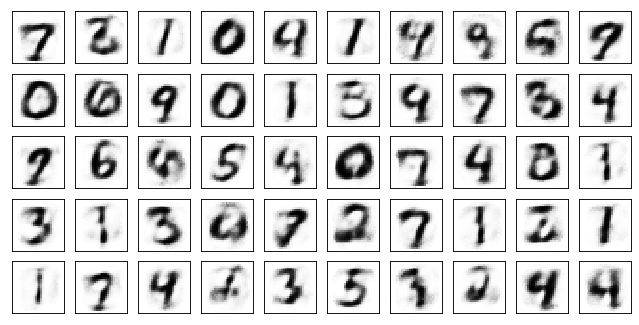

zeros


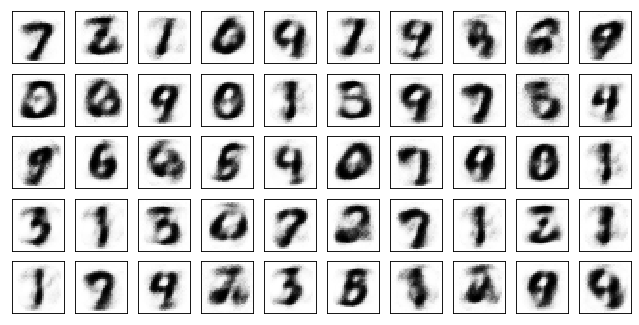

default


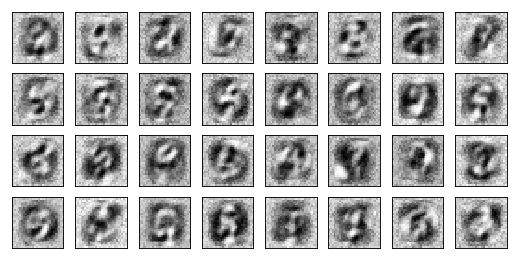

noise


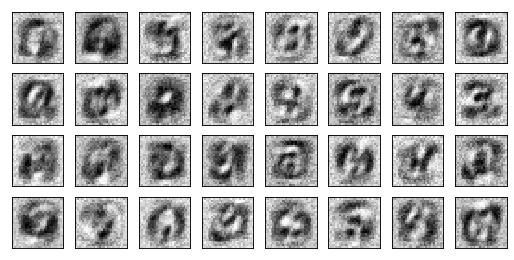

zeros


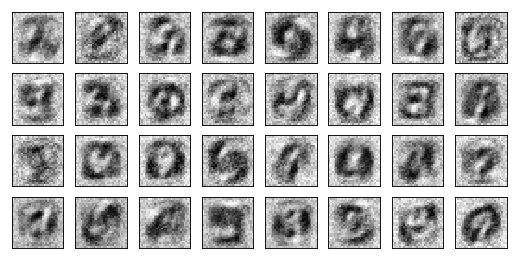

In [17]:
plot_mnist(data.data.numpy(), (5, 10))

for model in models.values():
    model.train()
plot_mnist(models['noise'].noise_mod(data).data.numpy(), (5, 10))
plot_mnist(models['zeros'].zero_inputs(data).data.numpy(), (5, 10))

for model in models.values():
    model.eval()

for k, model in models.items():
    print(k)
    plot_mnist(to_plot[k], (5, 10))
    
for k, model in models.items():
    print(k)
    plot_mnist(f_to_plot[k], (5, 10))
    
for k, model in models.items():
    print(k)
    plot_mnist(dec_to_plot[k], (8, 8))
